In [34]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

from pytz import timezone
from geopy.distance import geodesic

In [19]:
output_dir = '../metadata/27-05-2023'
filename = 'location-error.png'

In [31]:
start_location = (1.309743979078668, 103.89449080743935)

In [2]:
conn = psycopg2.connect(
    host="localhost",
    database="gpx",
    user="root",
    password="root"
)

In [56]:
query = """
WITH ordered_route_points AS (
    SELECT location
    FROM gpx_route
    ORDER BY id
),
route_linestring AS (
    SELECT ST_MakeLine(ST_Transform(location, 3857)) AS route
    FROM ordered_route_points
)

SELECT
    time,
    ST_Y(location) AS latitude,
    ST_X(location) AS longitude,
    ST_Distance(ST_Transform(location, 3857), (SELECT route FROM route_linestring)) AS distance_to_route
FROM
    garmin_route;
"""

with conn.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()

garmin_df = pd.DataFrame(rows, columns=["time", "latitude", "longitude", "distance_to_route"])
garmin_df['time'] = garmin_df['time'].apply(lambda x: x.astimezone(timezone('Asia/Singapore')))

garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-05-27 06:18:49+08:00,1.309699,103.896454,231.391652
1,2024-05-27 06:18:56+08:00,1.309665,103.896435,228.948959
2,2024-05-27 06:18:57+08:00,1.309670,103.896451,230.757277


In [57]:
garmin_df['distance'] = garmin_df.apply(lambda row: geodesic((row['latitude'], row['longitude']), start_location).meters, axis=1)
start_point_idx = garmin_df.iloc[:200]['distance'].idxmin()
end_point_idx = garmin_df.iloc[-200:]['distance'].idxmin()
garmin_df = garmin_df.iloc[start_point_idx:end_point_idx]

In [58]:
garmin_df['distance_to_route'].describe()

count    1062.000000
mean        6.444313
std         9.792494
min         0.002916
25%         1.467228
50%         3.645489
75%         7.527373
max        77.053014
Name: distance_to_route, dtype: float64

In [59]:
query = """
WITH ordered_route_points AS (
    SELECT location
    FROM gpx_route
    ORDER BY id
),
route_linestring AS (
    SELECT ST_MakeLine(ST_Transform(location, 3857)) AS route
    FROM ordered_route_points
)

SELECT
    time,
    ST_Y(location) AS latitude,
    ST_X(location) AS longitude,
    ST_Distance(ST_Transform(location, 3857), (SELECT route FROM route_linestring)) AS distance_to_route
FROM
    polar_route;
"""

with conn.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()

polar_df = pd.DataFrame(rows, columns=["time", "latitude", "longitude", "distance_to_route"])
polar_df['time'] = polar_df['time'].apply(lambda x: x.astimezone(timezone('Asia/Singapore')))

polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-05-27 06:19:27.641000+08:00,1.309362,103.896368,220.451582
1,2024-05-27 06:19:28.642000+08:00,1.309355,103.896353,218.818110
2,2024-05-27 06:19:29.642000+08:00,1.309360,103.896333,216.567873


In [60]:
polar_df['distance'] = polar_df.apply(lambda row: geodesic((row['latitude'], row['longitude']), start_location).meters, axis=1)
start_point_idx = polar_df.iloc[:200]['distance'].idxmin()
end_point_idx = polar_df.iloc[-200:]['distance'].idxmin()
polar_df = polar_df.iloc[start_point_idx:end_point_idx]

In [61]:
polar_df['distance_to_route'].describe()

count    4578.000000
mean        9.294731
std        10.092639
min         0.000022
25%         2.806925
50%         7.027681
75%        12.141422
max        80.102673
Name: distance_to_route, dtype: float64

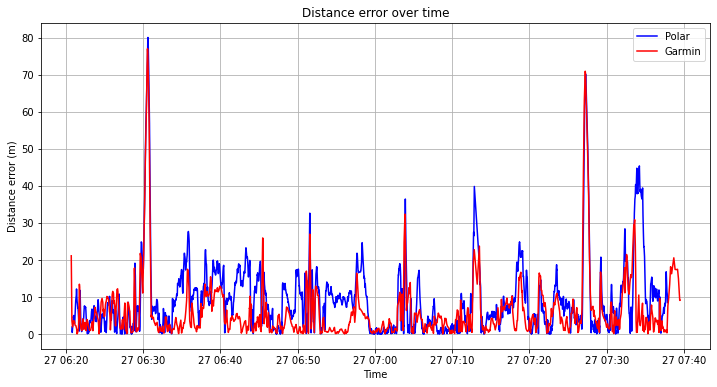

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.title('Distance error over time')
plt.legend()
plt.grid(True)
plt.savefig(output_dir + '/' + filename)